In [1]:
#This part of code is used to read in and analysis in situ observations from GNIP
import numpy as np
import pandas as pd
import xarray as xr

C:\Users\jiang\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#step1: all unique from eacjh csv collected
asite=[]
for j in range(2,34):
    jn=str(j)
    ams=pd.read_csv('/change to your path/Wiser_BulkData_'+jn+'.csv')
    a1=np.unique(ams['WMO Code'])
    asite=np.append(asite,a1)

In [3]:
#step2: drop duplicate values
acsite=np.unique(asite)

In [4]:
#step3: new loop to abstract station data
amf=pd.DataFrame()
for i in range(len(acsite)):
    c1=[]
    for j in range(2,34):
        jn=str(j)
        ams=pd.read_csv('/change to your path/Wiser_BulkData_'+jn+'.csv')
        c1=np.append(c1,np.count_nonzero(ams['WMO Code']==acsite[i]))
    jr=np.where(c1==np.max(c1))
    ams2=pd.read_csv('/change to your path/Wiser_BulkData_'+str(jr[0][0]+2)+'.csv')
    amf=pd.concat([amf,ams2[ams2["WMO Code"] == acsite[i]]],ignore_index=True)    

In [5]:
#step4 get the location of all selected sites:
sff=[]
lonff=[]#with the wanted time coverage
latff=[]
lontf=[]
lattf=[]
for i in range(len(acsite)):
    ia=amf.index[(amf["WMO Code"] == acsite[i])]
    dl=amf["Date"][ia]
    lon=amf["Longitude"][ia]
    lat=amf["Latitude"][ia]
    lontf=np.append(lontf,lon.values[0])
    lattf=np.append(lattf,lat.values[0])
    yl=[]
    for j in range(len(ia)):
        yl=np.append(yl,int(dl.values[j][0:4]))
    ylr=np.unique(yl)
    n1=np.count_nonzero(ylr<=2020)
    n2=np.count_nonzero(ylr<2002)
    if len(ylr)>=5 and (n1-n2)>=5:
        sff=np.append(sff,i)
        lonff=np.append(lonff,lon.values[0])
        latff=np.append(latff,lat.values[0])

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

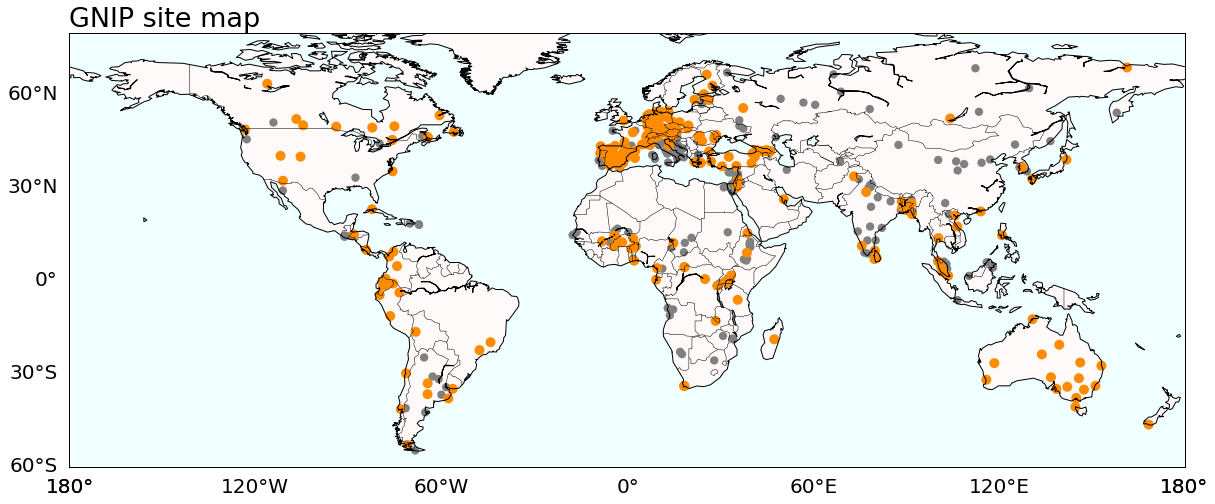

In [7]:
#show the station map
fig=plt.figure(figsize=(20,20),linewidth=2)
ax1 = fig.add_subplot(111)
m = Basemap(llcrnrlon=-180,llcrnrlat=-60,urcrnrlon=180,urcrnrlat=80, epsg=4326)
m.drawparallels(range(-90, 91, 30), labels=[True, False, False, False], color='none', fontsize=20)
m.drawmeridians(range(-180, 181, 60), labels=[False, False, False, True], color='none', fontsize=20)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='azure')
m.fillcontinents(color='snow',lake_color='azure')
x,y = m(lontf, lattf)
x2,y2 = m(lonff, latff)
#df_wam=maskoceans(x,y,dfra[17]*100,inlands=True)
sc = plt.scatter(x,y, c='gray', s=70, edgecolors='none')#all
sc2 = plt.scatter(x2,y2, c='darkorange', s=100, edgecolors='none')#satisfied
ax1.set_title('GNIP site map', loc='left',fontsize=27)
plt.show() 

In [8]:
#step5 read P, T data 
#double check satisfied site
#filtered dataframe
amff=amf.copy()#kee
sftr=np.setdiff1d(np.arange(461),sff)
for i in sftr:
    amff.drop(amf.index[(amf["WMO Code"] == np.unique(amf['WMO Code'])[i])],axis=0,inplace=True)
snt2=len(np.unique(amff['WMO Code']))#total number of site -- make sure the algorithm works

lor=[]
lar=[]
atr=[]
dtr=[]
ptr=[]
ttr=[]
ylr=[]
mlr=[]
sfcode=[]
for i in range(snt2):
    ia=amff.index[(amff["WMO Code"] == np.unique(amff['WMO Code'])[i])]
    dl=amff["Date"][ia]
    dt=amff["H2"][ia]
    at=amff["Altitude"][ia]
    pt=amff["Precipitation"][ia]
    tt=amff["Air Temperature"][ia]
    lon=amff["Longitude"][ia]
    lat=amff["Latitude"][ia]
    yl=[]
    ml=[]
    for j in range(len(ia)):
        yl=np.append(yl,int(dl.values[j][0:4]))
        ml=np.append(ml,int(dl.values[j][5:7]))
    yls=[]
    mls=[]
    pts=[]
    ats=[]
    dts=[]
    tts=[]
    los=[]
    las=[]
    for k in range(len(yl)):
        if yl[k]>=2002 and yl[k]<=2020:#original 2004-2010
            ats=np.append(ats,at.values[k])
            dts=np.append(dts,dt.values[k])
            pts=np.append(pts,pt.values[k])
            tts=np.append(tts,tt.values[k])
            yls=np.append(yls,yl[k])
            mls=np.append(mls,ml[k])
            los=np.append(los,lon.values[k])
            las=np.append(las,lat.values[k])
    if len(dts)>=60 and np.count_nonzero(np.isnan(dts))<len(dts):# at least 5-yr data
        sfcode=np.append(sfcode,np.unique(amff['WMO Code'])[i])
        lor.append(los)
        lar.append(las)
        ylr.append(yls)
        mlr.append(mls)
        atr.append(ats) 
        ptr.append(pts) 
        ttr.append(tts) 
        dtr.append(dts) 

In [9]:
#step6: monthly variable
pre_mm=np.zeros((len(sfcode),12))*np.nan#monthly mean raifall
tem_mm=np.zeros((len(sfcode),12))*np.nan#monthly mean temperature
dtd_mm=np.zeros((len(sfcode),12))*np.nan#monthly mean delta_D
pre_cm=np.zeros(len(sfcode))*np.nan#climatologically monthly mean rainfall
for i in range(len(sfcode)):
    pre_cm[i]=np.nanmean(ptr[i])
    pli=ptr[i]
    ali=ttr[i]
    dli=dtr[i]
    mli=mlr[i]
    for mo in range(1,13):
        ptilt=[]
        atilt=[]
        dtilt=[]
        for k in range(len(mlr[i])):
            if mli[k]==mo:
                ptilt=np.append(ptilt,pli[k])
                atilt=np.append(atilt,ali[k])
                dtilt=np.append(dtilt,dli[k])
        pre_mm[i,mo-1]=np.nanmean(ptilt)
        tem_mm[i,mo-1]=np.nanmean(atilt)
        dtd_mm[i,mo-1]=np.nanmean(dtilt)
#lontitude, latitude information
lonp=[]
latp=[]
for i in range(len(sfcode)):
    lonp=np.append(lonp,lor[i][0])
    latp=np.append(latp,lar[i][0])       

C:\Users\jiang\AppData\Local\Temp\ipykernel_26536\965297421.py:7: RuntimeWarning: Mean of empty slice
  pre_cm[i]=np.nanmean(ptr[i])
C:\Users\jiang\AppData\Local\Temp\ipykernel_26536\965297421.py:21: RuntimeWarning: Mean of empty slice
  pre_mm[i,mo-1]=np.nanmean(ptilt)
C:\Users\jiang\AppData\Local\Temp\ipykernel_26536\965297421.py:22: RuntimeWarning: Mean of empty slice
  tem_mm[i,mo-1]=np.nanmean(atilt)
C:\Users\jiang\AppData\Local\Temp\ipykernel_26536\965297421.py:23: RuntimeWarning: Mean of empty slice
  dtd_mm[i,mo-1]=np.nanmean(dtilt)


In [10]:
#step7: transitional season delta_D
#transitional month: logistic: 1.climatological monthly -- 2.anomally (minus climatology mean) --3.stably above cmean (DSE, minimum cumulative value)
dse_p=np.zeros((len(sfcode),4))*np.nan#transitional month
dt_p=np.zeros((len(sfcode),4))*np.nan#transitional month delta_D
tse_p=np.zeros((len(sfcode),4))*np.nan#transitional month T
for i in range(len(sfcode)):
    if np.count_nonzero(np.isnan(pre_mm[i,:]))<=6:#tackle with mising value: full & partial
        pano=pre_mm[i,:]-pre_cm [i]
        pano2=np.zeros(12)*np.nan
        pano2[0]=pano[0]
        for mo in range(1,12):
            pano2[mo]=np.nansum(pano[0:mo+1])
        if latp[i]>=-10 and latp[i]<=10:# 10S-10N, tackle with potential bimodal rainfall seasonal cycle
            dse_p[i,0]=np.where(abs(pano2[0:6]-np.nanmin(pano2[0:6]))<0.01)[0][0]   
            dse_p[i,1]=np.where(abs(pano2[0:6]-np.nanmax(pano2[0:6]))<0.01)[0][0]
            dse_p[i,2]=np.where(abs(pano2[6:12]-np.nanmin(pano2[6:12]))<0.01)[0][0]
            dse_p[i,3]=np.where(abs(pano2[6:12]-np.nanmax(pano2[6:12]))<0.01)[0][0]
            tse_p[i,0]=tem_mm[i,:][int(dse_p[i,0])]
            tse_p[i,1]=tem_mm[i,:][int(dse_p[i,1])]
            tse_p[i,2]=tem_mm[i,:][int(dse_p[i,2])]
            tse_p[i,3]=tem_mm[i,:][int(dse_p[i,3])]
            dt_p[i,0]=dtd_mm[i,:][int(dse_p[i,0])]
            dt_p[i,1]=dtd_mm[i,:][int(dse_p[i,1])]
            dt_p[i,2]=dtd_mm[i,:][int(dse_p[i,2])]
            dt_p[i,3]=dtd_mm[i,:][int(dse_p[i,3])]
        else:#start and end of the single rainy season
            dse_p[i,0]=np.where(abs(pano2-np.nanmin(pano2))<0.01)[0][0]  
            tse_p[i,0]=tem_mm[i,:][int(dse_p[i,0])]
            dt_p[i,0]=dtd_mm[i,:][int(dse_p[i,0])]
            dse_p[i,1]=np.where(abs(pano2-np.nanmax(pano2))<0.01)[0][0]  
            tse_p[i,1]=tem_mm[i,:][int(dse_p[i,1])]
            dt_p[i,1]=dtd_mm[i,:][int(dse_p[i,0])]

In [11]:
#step 8: interpolate to 2-deg
#coordination aligned with the satellite isotope data
#test single month [from the free atmos version]
te1=xr.open_dataset('/change to your path/TES-Aura_L2-HDO-Nadir_2006-04_v006_Litev01.00.nc')
xi = np.arange(te1.Longitude.min(), te1.Longitude.max(), 2)
yi = np.arange(te1.Latitude.max(), te1.Latitude.min(), -2) 

In [12]:
#mask of crop grids
#2 deg#######
imai0=np.load('/change to your path/imai0_full.npy',allow_pickle=True)
y3d=np.arange(70,-60.1,-2.)
x3d=np.arange(-170,180.1,2.)
lon3s,lat3s=np.meshgrid(x3d, y3d)

imai_2degf=np.zeros((66,176))*np.nan
for y in range(66):
    for x in range(176):
        al=[imai0[0,y,x],imai0[1,y,x],imai0[2,y,x],imai0[3,y,x],imai0[4,y,x]]
        if np.count_nonzero(np.array(al)>0)>0:
            imai_2degf[y,x]=np.nanmax(al)

In [13]:
#surface dD condition
dt_sf=np.zeros((66,176))*np.nan
dtlim=[[[]for x in range(176)] for y in range(66)]
for y in range(66):
    for x in range(176):
        if imai_2degf[y,x]>2:#strict cropland selection
            lac=yi[y+5]
            loc=xi[x+4]
            dist=[]
            for j in range(len(dse_p)):
                dist=np.append(dist,(lac-latp[j])**2+(loc-lonp[j])**2)
            dt1=dt_p[np.where(dist==np.sort(dist)[0]),:]
            dt2=dt_p[np.where(dist==np.sort(dist)[1]),:]
            dt3=dt_p[np.where(dist==np.sort(dist)[2]),:]
            tt1=tse_p[np.where(dist==np.sort(dist)[0]),:]
            tt2=tse_p[np.where(dist==np.sort(dist)[1]),:]
            tt3=tse_p[np.where(dist==np.sort(dist)[2]),:]
            dn1=dse_p[np.where(dist==np.sort(dist)[0]),:]
            dn2=dse_p[np.where(dist==np.sort(dist)[1]),:]
            dn3=dse_p[np.where(dist==np.sort(dist)[2]),:]
            if np.count_nonzero(tt1<5)!=0:
                dt1=np.delete(dt1,np.where(tt1<5))
            if np.count_nonzero(tt2<5)!=0:
                dt2=np.delete(dt2,np.where(tt2<5))
            if np.count_nonzero(tt3<5)!=0:
                dt3=np.delete(dt3,np.where(tt3<5))
            if np.count_nonzero(tt1<5)!=0:
                dn1=np.delete(dn1,np.where(tt1<5))
            if np.count_nonzero(tt2<5)!=0:
                dn2=np.delete(dn2,np.where(tt2<5))
            if np.count_nonzero(tt3<5)!=0:
                dn3=np.delete(dn3,np.where(tt3<5))

            dtli0=np.append(dt1,dt2)
            dtli=np.append(dtli0,dt3)
            dnli0=np.unique(np.append(dn1,dn2))
            dnt=np.unique(np.append(dnli0,dn2))
            if np.count_nonzero(np.isnan(dtli))!=0:
                dtli=np.delete(dtli,np.where(np.isnan(dtli)))
                dnt=np.delete(dnt,np.where(np.isnan(dtli)))
                
            if np.count_nonzero(dtli>0)!=0:
                dtli=np.delete(dtli,np.where(dtli>0))
                dnt=np.delete(dnt,np.where(dtli>0))
            
            if np.count_nonzero(np.isnan(dnt))!=0:
                dnt=np.delete(dnt,np.where(np.isnan(dnt)))
                
            if len(dtli)!=0:
                dt_sf[y,x]=np.nanmean(dtli)
                dtlim[y][x]=np.append(dtlim[y][x],dnt)

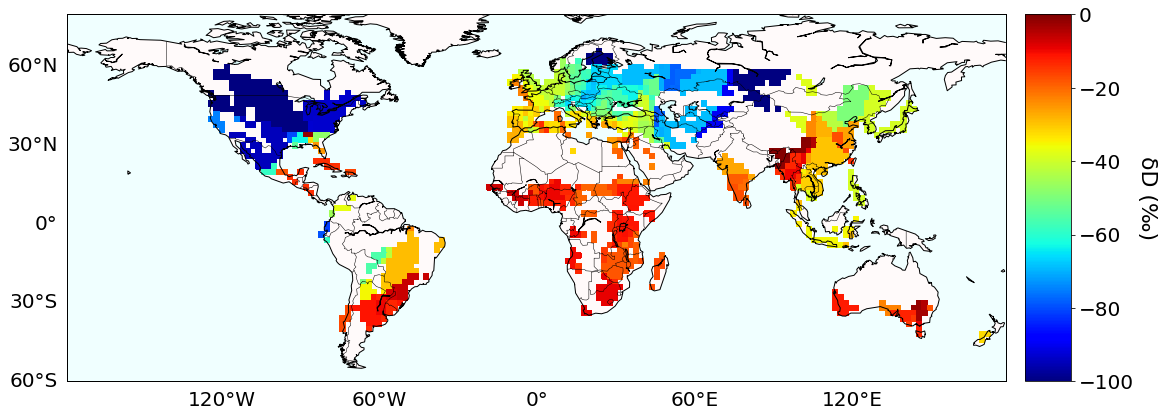

In [14]:
fig=plt.figure(figsize=(18,20),linewidth=2)
ax1 = fig.add_subplot(111)
m = Basemap(llcrnrlon=-179,llcrnrlat=-60,urcrnrlon=179,urcrnrlat=80, epsg=4326)
m.drawmapboundary(fill_color='azure')
m.fillcontinents(color='snow',lake_color='lightcyan')
shade=m.pcolor(lon3s,lat3s,dt_sf,vmin=-100,vmax=0,cmap=plt.cm.jet)
cbar=m.colorbar(shade)
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_ylabel('\u03B4D (‰)',fontsize=22,va='bottom',rotation=-90)
m.drawparallels(range(-90, 91, 30), labels=[True, False, False, False], color='none', fontsize=20)
m.drawmeridians(range(-180, 181, 60), labels=[False, False, False, True], color='none', fontsize=20)
m.drawcoastlines()
m.drawcountries()